# Menu <a class="anchor" id="menu"></a>
* [1. Mise en place](#init)
* [2. Feature Engineering](#feature_engineering)
    * [2.1 Créons quelques features métiers](#feature_engineering_crea)
    * [2.2 Testons l'effet des nouvelles features](#feature_engineering_test)
        * [Logistic Regression](#models_linear_new_features)
        * [XGBoost Classifier](#models_xgboost_new_features)
        * [Revue des scores](#models_new_features_scores)
* [3. Feature Selection](#feature_selection)
    * [3.1 En fonction de l'importance des features dans le modèle (SelectFromModel)](#feature_selection_method1)
    * [3.2 En fonction du score chi2 des features (SelectKBest / chi2)](#feature_selection_method2)
    * [3.3 Par éliminiation récursive des features (RFECV)](#feature_selection_method3)
    * [3.4 Par comparaison avec les importance nulles](#feature_selection_method4)
    * [3.5 Testons l'effet de la selection](#feature_selection_test)
        * [Logistic Regression](#models_linear_features_selection)
        * [XGBoost Classifier](#models_xgboost_features_selection)
        * [Revue des scores](#models_features_selection_scores)
* [4. Création d'une mesure adaptée au métier](#custom_metric)
    * [4.1 F-measure](#custom_metric_solution)
    * [4.2 Testons l'effet de la nouvelle metric](#custom_metric_test)
        * [Logistic Regression](#models_linear_custom_metric)
        * [XGBoost Classifier](#models_xgboost_custom_metric)
        * [Revue des scores](#models_custom_metric_scores)
* [5. Augmentation du training-set](#extra_data)
    * [5.1 Entrainons et testons le modèle final](#final_model)
* [6. Interpretation](#interpretation)
    * [6.1 Interpretation globale](#interpretation_globale)
    * [6.2 Interpretation locale](#interpretation_locale)

# 1. Mise en place <a class="anchor" id="init"></a> [⇪](#menu)

### Chargeons les librairies utiles

In [1]:
import time
import copy as cp
from collections import defaultdict
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly_express as px

random_seed = 0
np.random.seed(random_seed) # Seed the unexpected randomness of this world

import warnings
warnings.filterwarnings('ignore')

import gc
gc.enable()

### Chargons le jeu de données

In [2]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [3]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    #usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_train.shape

(307511, 122)

### Faisons quelques réglages pour mieux voir les DataFrames pandas

In [4]:
pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

### Supprimons les colonnes que nous savons inutiles

In [5]:
data_application_train.drop(['SK_ID_CURR', 'FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4'], axis=1, inplace=True)
data_application_train.shape

(307511, 116)

### Supprimons les outliers

In [6]:
def clean_outliers(data):
    data['DAYS_EMPLOYED'].mask(data['DAYS_EMPLOYED']>0, np.nan, inplace=True)
    
    for col in ['AMT_INCOME_TOTAL', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT']:
        data[col].mask(data[col] > data[col].quantile(0.99), np.nan, inplace=True)
        
    return data

data_application_train = clean_outliers(data_application_train)

### Réduisons la taille du jeu de données pour les essais préliminaires des différents modèles

In [7]:
sample_size_base = 30000
data_work = data_application_train[:sample_size_base].copy()

In [8]:
data_work.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       1         Cash loans           M         False             True   
1       0         Cash loans           F         False            False   
2       0    Revolving loans           M          True             True   
3       0         Cash loans           F         False             True   
4       0         Cash loans           M         False             True   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working  Secondary / secondary special   
1          Family    State servant               Higher education   
2   Unaccompanied          Working  Secondary / secondary special   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0  Single / not married  House / apartment                    0.018801   
1               Married  House / apartment                    0.003541   
2  Single / not married  House / apartment                    0.010032   
3        Civil marriage  House / apartment                    0.008019   
4  Single / not married  House / apartment                    0.028663   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0       -9461         -637.0            -3648.0            -2120          NaN   
1      -16765        -1188.0            -1186.0             -291          NaN   
2      -19046         -225.0            -4260.0            -2531         26.0   
3      -19005        -3039.0            -9833.0            -2437          NaN   
4      -19932        -3038.0            -4311.0            -3458          NaN   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

  OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0        Laborers              1.0                     2   
1      Core staff              2.0                     1   
2        Laborers              1.0                     2   
3        Laborers              2.0                     2   
4      Core staff              1.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                  WEDNESDAY   
1                            1                     MONDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                   THURSDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                   

### Définissons les fonctions permettant de préparer le jeu de données

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler #, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [10]:
def fit_labels(data):
    """ Prepare the encoder for the categorical columns.
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    # Define columns
    oe_targets = [x for x in ['NAME_EDUCATION_TYPE', 'WEEKDAY_APPR_PROCESS_START'] if x in data.columns]
    ohe_targets = [x for x in data.select_dtypes(exclude='number').columns if x not in oe_targets]
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_model):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

In [11]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    
    return dt

In [12]:
def fit_normalizer(data):
       
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    return scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [13]:
def prepare_dataset(data):
    X_full = data.copy()
    
    # Split the dataset
    Y_full = X_full['TARGET']
    X_full.drop(['TARGET'], axis=1, inplace=True)
    
    X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)
    
    print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")
    
    # Encode the categorical variables
    oe_model, ohe_model = fit_labels(X_train)
    X_train = transform_labels(X_train, oe_model, ohe_model)
    X_test = transform_labels(X_test, oe_model, ohe_model)
    
    # Imput missing values
    imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)
    X_train = impute(X_train, imputer_model)
    X_test = impute(X_test, imputer_model)
    
    # Normalize
    model_scaler = fit_normalizer(X_train)
    X_train = normalize(X_train, model_scaler)
    X_test = normalize(X_test, model_scaler)
    
    return X_train, X_test, y_train, y_test, oe_model, ohe_model, imputer_model, model_scaler

### Définissons quelques fonctions pour faciliter la gestion des scores *(rapports, graphiques, enregistrement)* <a class="anchor" id="models_prepare_metrics"></a> [⇪](#menu)

In [14]:
from sklearn.metrics import accuracy_score,\
                            recall_score,\
                            precision_score,\
                            roc_auc_score, roc_curve, RocCurveDisplay, \
                            classification_report, \
                            confusion_matrix, ConfusionMatrixDisplay, \
                            f1_score, \
                            average_precision_score, \
                            fbeta_score, make_scorer

In [15]:
beta_value = 2
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=beta_value)
f2_scorer = make_scorer(fbeta_score, beta=2)

In [16]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---".ljust(100,'-'),"\n\n", report)

In [17]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---".ljust(100,'-'),"\n")
    plt.show()

In [18]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- ROC AUC ---".ljust(100,'-'),"\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [19]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- PRECISION RECALL AUC ---".ljust(100,'-'), "\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [20]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    custom =  scores.get('custom', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, custom, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [21]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'Custom', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores_tuning.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, alone=False, **scores):
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'custom': f2_score(y_ref, y_pred),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
            
    print('-'*100,f'These information are based on the best estimator of the above cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    print(f"--- {method_name} ---".ljust(100,'-'),"\n\n",scores_str, sep="")
          
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        if alone == False:
            y_preds[method_name] = y_pred_proba
            y_preds_param = y_preds
        else:
            y_preds_param = {method_name:y_pred_proba}
        print_rocauc(y_ref, y_preds_param)
        print_prauc(y_ref, y_preds_param)

In [22]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [23]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [24]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # --> GridSearchCV trop lent

def fit_model(model_name, model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    grid_model = RandomizedSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, random_state=random_seed)#, refit=refit_scoring)
    #grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=0)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{str(scoring).upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{str(scoring).upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

In [25]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

### Définissons la méthode de cross-validation utilisée pour tous les tests

In [26]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# 2. Feature Engineering<a class="anchor" id="feature_engineering"></a> [⇪](#menu)

## Créons quelques features métiers<a class="anchor" id="feature_engineering_crea"></a> [⇪](#menu)
 - j'ai exploré les différentes variables et essayé de créer celles qui me paraissaient logiques,
 - j'ai cherché sur les notebooks utilisant ce dataset pour voir ce qui avait été fait,
 - j'ai essayé celles suggérées par mon mentor.

>#### Quelle fraction du bien convointé représente le montant du crédit ?
>
>> data['FRAC_GOODS_PRICE'] = data.AMT_CREDIT / data.AMT_GOODS_PRICE
>
>#### Quel age (en années) avait le client quand il a obtenu son emploi actuel ?
>
>> data['AGE_EMPLOYEMENT'] = (data.DAYS_BIRTH - data.DAYS_EMPLOYED) / -365
>
>#### Quel montant de revenu est disponible pour chaque membre de la famille ?
>
>> data['INCOME_PER_FAM_MEMBER'] = data.AMT_INCOME_TOTAL / data.CNT_FAM_MEMBERS
>
>#### Combien de demandes de crédits ont été faites au total ?
>
>> data['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data.AMT_REQ_CREDIT_BUREAU_HOUR +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_DAY +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_WEEK +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_MON +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_QRT +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_YEAR
>
>#### Quelle fraction des revenus représente chaque annuité ?
>
>> data['ANNUITY_INCOME_RATIO'] = data.AMT_INCOME_TOTAL / data.AMT_ANNUITY
>
>#### Quel est le reste à payer sur le bien à l'origine de la demande de crédit ?
>
>> data['DIFF_GOOD_PRICE_CREDIT'] = data.AMT_GOODS_PRICE - data.AMT_CREDIT
>
>#### Quel est l'age en années ?
>
>> data['AGE_INT'] = data.DAYS_BIRTH / -365
>
>#### Quelle fraction de son temps de vie représente son dernier emploi ?
>
>> data['DAYS_EMPLOYED_PERC'] = data.DAYS_EMPLOYED / data.DAYS_BIRTH

### Ajoutons ces nouvelles features au dataset de travail

In [27]:
def add_new_features( data ):
    data = data.copy()
    
    data['FRAC_GOODS_PRICE'] = data.AMT_CREDIT / data.AMT_GOODS_PRICE
    data['AGE_EMPLOYEMENT'] = (data.DAYS_BIRTH - data.DAYS_EMPLOYED) / -365
    data['INCOME_PER_FAM_MEMBER'] = data.AMT_INCOME_TOTAL / data.CNT_FAM_MEMBERS
    data['AMT_REQ_CREDIT_BUREAU_TOTAL'] =   data.AMT_REQ_CREDIT_BUREAU_HOUR + data.AMT_REQ_CREDIT_BUREAU_DAY + data.AMT_REQ_CREDIT_BUREAU_WEEK + data.AMT_REQ_CREDIT_BUREAU_MON + data.AMT_REQ_CREDIT_BUREAU_QRT + data.AMT_REQ_CREDIT_BUREAU_YEAR
    data['ANNUITY_INCOME_RATIO'] = data.AMT_INCOME_TOTAL / data.AMT_ANNUITY
    data['DIFF_GOOD_PRICE_CREDIT'] = data.AMT_GOODS_PRICE - data.AMT_CREDIT
    data['AGE_INT'] = data.DAYS_BIRTH / -365
    data['DAYS_EMPLOYED_PERC'] = data.DAYS_EMPLOYED / data.DAYS_BIRTH
    #data['INCOME_CREDIT_PERC'] = data.AMT_INCOME_TOTAL / data.AMT_CREDIT
    #data['PAYMENT_RATE'] = data.AMT_ANNUITY / data.AMT_CREDIT
    
    return data

In [28]:
data_work = add_new_features(data_work)

### Vérifions la corrélation linéaire *(pearson)* des nouvelles features avec TARGET

Pour déterminer si une nouvelle variable est utile, nous pouvons calculer le coefficient de corrélation de Pearson entre cette variable et la cible.

Ce coefficient mesure la force d'une relation linéaire entre deux variables et s'étend de -1 (linéaire parfaitement négatif) à +1 (linéaire parfaitement positif).

Ce n'est pas la meilleure mesure de l'utilité d'une nouvelle variable, mais elle peut donner une première approximation de l'utilité d'une variable pour un modèle d'apprentissage automatique. Plus la valeur du coefficient est élevée, plus un changement dans cette variable est susceptible d'affecter la valeur de la cible. Par conséquent, nous recherchons les variables ayant la plus grande valeur absolue par rapport à la cible.

In [29]:
correlations = data_work.corr(method='pearson')

In [30]:
new_features = [
    'FRAC_GOODS_PRICE', 
    'AGE_EMPLOYEMENT', 
    'INCOME_PER_FAM_MEMBER', 
    'AMT_REQ_CREDIT_BUREAU_TOTAL', 
    'ANNUITY_INCOME_RATIO', 
    'DIFF_GOOD_PRICE_CREDIT', 
    'AGE_INT',
    'DAYS_EMPLOYED_PERC',
    'INCOME_CREDIT_PERC',
    'PAYMENT_RATE',
]

corr_target = correlations.TARGET.sort_values(ascending=False)
for i, (key, value) in enumerate(corr_target.iteritems()):
    if key in new_features:
        print(f"{key.rjust(40)} : {value:6.4f}")

                        FRAC_GOODS_PRICE : 0.0636
             AMT_REQ_CREDIT_BUREAU_TOTAL : 0.0188
                   INCOME_PER_FAM_MEMBER : -0.0150
                         AGE_EMPLOYEMENT : -0.0207
                  DIFF_GOOD_PRICE_CREDIT : -0.0240
                    ANNUITY_INCOME_RATIO : -0.0288
                      DAYS_EMPLOYED_PERC : -0.0739
                                 AGE_INT : -0.0809


> A-priori elles ne sont pas toutes intéressantes pour notre modèle, mais on ne peut pas prévoir les intéractions plus complexe qu'elles pouraient avoir avec d'autres features avec cette simple mesure. 

## Testons les modèles sélectionnés avec les nouvelles features<a class="anchor" id="feature_engineering_test"></a> [⇪](#menu)

--- 
>#### Voici pour rappel les deux modèles que l'on a choisi d'essayer d'améliorer:
> - la `Balanced LogisticRegression`:
>   - ROC_AUC : 0.7324
>   - F1 : 0.2405
>   - ACCURACY : 0.6716
>   - PRECISION : 0.1475
>   - RECALL : 0.6500
>   - AVERAGE_PRECISION : 0.2080
> - le `Balanced XGBClassifier`:
>   - ROC_AUC : 0.7212
>   - F1 : 0.2377
>   - ACCURACY : 0.6736
>   - PRECISION : 0.1461
>   - RECALL : 0.6361
>   - AVERAGE_PRECISION : 0.2064

---

### Préparons le jeu de données

In [31]:
X_train, X_test, y_train, y_test, _, _, _, _ = prepare_dataset(data_work)

X_train: 85.0% | X_test: 15.0%


### Testons l'effet des nouvelles features sur la Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [32]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, loguniform

In [33]:
max_lr_iter = 3000

param_grid_log = [
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [34]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7047
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7210
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7025
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7024
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7001

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7061 (std:0.0082)

----------------------------------------------------------------------------------------------------


In [35]:
grd_log['grid'].best_params_

{'C': 0.09469170308457578,
 'class_weight': 'balanced',
 'l1_ratio': 0.925596638292661,
 'max_iter': 3000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features] ----------------------------------------------------------------

             ROC_AUC : 0.7382
                  F1 : 0.2459
            ACCURACY : 0.6756
           PRECISION : 0.1510
              RECALL : 0.6611
   AVERAGE_PRECISION : 0.2089
              CUSTOM : 0.3946

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.66      0.25       360

      accuracy                           0.68      4500
     macro avg       0.55      0.67      0.52      45

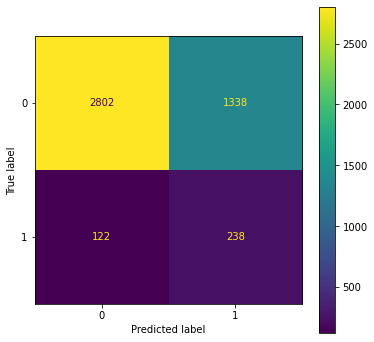

--- ROC AUC ---------------------------------------------------------------------------------------- 



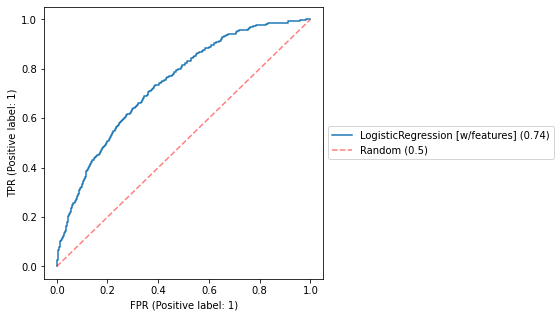

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



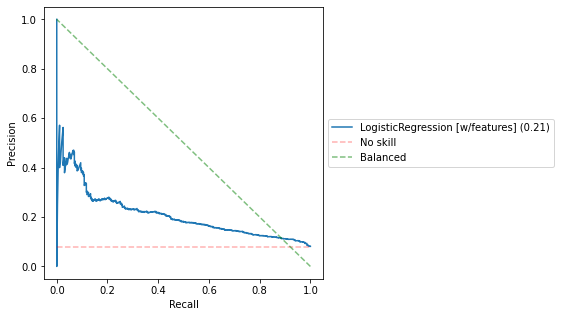

In [36]:
get_scores(f"{model_name} [w/features]", **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [37]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23141204199700025) for this model is reached with a threshold of 0.41600000000000004


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features] ----------------------------------------------------

             ROC_AUC : 0.7382
                  F1 : 0.2198
            ACCURACY : 0.5582
           PRECISION : 0.1280
              RECALL : 0.7778
   AVERAGE_PRECISION : 0.2089
              CUSTOM : 0.3859

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.54      0.69      4140
Prediction = 1       0.13      0.78      0.22       360

      accuracy                           0.56      4500
     macro avg       0.55      0.66      0.46      45

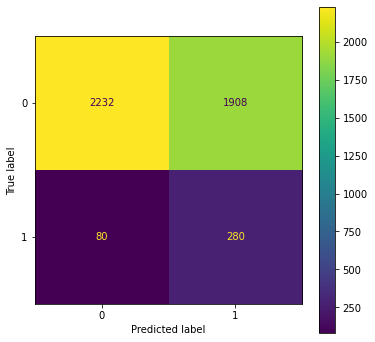

In [38]:
get_scores(f"{model_name} [w/threshold + features]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

### Testons l'effet des nouvelles features sur le XGBoost Classifier<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [39]:
from xgboost import XGBClassifier

In [40]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [41]:
param_grid_xgb = {
    'scale_pos_weight':[scale_weigth],
    'seed':[random_seed],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 20),
    'learning_rate': [None, 0.1, 0.01, 0.05]
}

In [42]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid_xgb,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7219
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7272
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7114
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7147
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7168

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7184 (std:0.0072)

----------------------------------------------------------------------------------------------------


In [43]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'scale_pos_weight': 11.481644640234949,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 60,
 'max_depth': 3,
 'learning_rate': 0.05,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features] ---------------------------------------------------------------------

             ROC_AUC : 0.7211
                  F1 : 0.2391
            ACCURACY : 0.6776
           PRECISION : 0.1474
              RECALL : 0.6333
   AVERAGE_PRECISION : 0.1999
              CUSTOM : 0.3817

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      4140
Prediction = 1       0.15      0.63      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

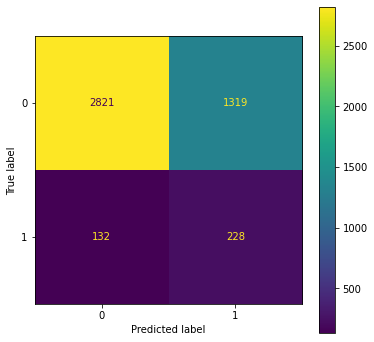

--- ROC AUC ---------------------------------------------------------------------------------------- 



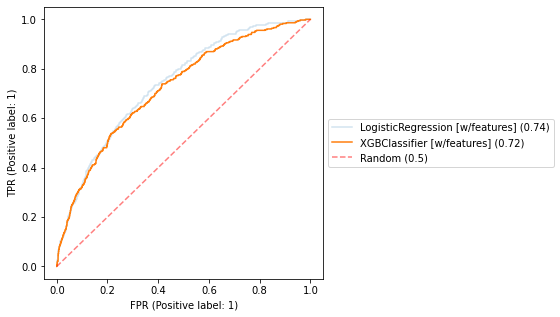

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



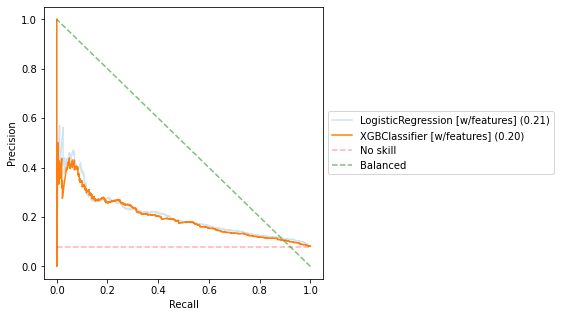

In [44]:
get_scores(f"{model_name} [w/features]", **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [45]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.25542697862995184) for this model is reached with a threshold of 0.47300000000000003


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/thresholding + features] ------------------------------------------------------

             ROC_AUC : 0.7211
                  F1 : 0.2273
            ACCURACY : 0.6269
           PRECISION : 0.1362
              RECALL : 0.6861
   AVERAGE_PRECISION : 0.1999
              CUSTOM : 0.3796

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.62      0.75      4140
Prediction = 1       0.14      0.69      0.23       360

      accuracy                           0.63      4500
     macro avg       0.55      0.65      0.49      45

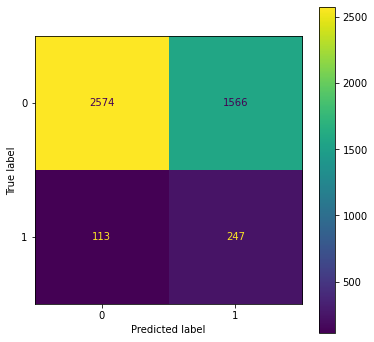

In [46]:
get_scores(f"{model_name} [w/thresholding + features]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

### Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [47]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  Precision    Recall
0  LogisticRegression [w/features]  0.738159  0.245868   0.151015  0.661111
2       XGBClassifier [w/features]  0.721111  0.239119   0.147382  0.633333

In [48]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

Method   ROC AUC  F1 score  Precision  \
1  LogisticRegression [w/threshold + features]  0.738159  0.219780   0.127971   
3    XGBClassifier [w/thresholding + features]  0.721111  0.227335   0.136238   

     Recall  
1  0.777778  
3  0.686111

#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [49]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  \
23                   Balanced LogisticRegression  0.732390  0.240493   
24  Balanced LogisticRegression [w/thresholding]  0.732390  0.199808   
29                        Balanced XGBClassifier  0.721245  0.237675   
30       Balanced XGBClassifier [w/thresholding]  0.721245  0.225911   

    Precision    Recall  
23   0.147541  0.650000  
24   0.112921  0.866667  
29   0.146139  0.636111  
30   0.135434  0.680556

### Bilan de la section

> On constate qu'avec les nouvelles features, tous les scores de la LogisticRegression augmentent nettement. C'est cependant moins marqué avec le XGBClassifier; si F1, Accuracy et Precision sont effectivement à la hausse, les autres scores sont stables ou très légèrement à la baisse (de l'ordre de 1e-3 ou 1e-4) avec par exemple un ROC_AUC qui passe de 0.7213 à 0.7211.

> La modification ayant un impact significatif sur la LogisticRegression et un impact pas vraiment négatif sur le XGBClassifier, nous allons utiliser ces nouvelles features pour la suite de nos recherches.

In [50]:
import FreeMobileSMS as sms
sms.send("Feature Engineering - Done", stop=False)

# 3. Feature selection <a class="anchor" id="feature_selection"></a> [⇪](#menu)

> Les trois principaux avantages de la feature selection sont les suivants :
> - **Réduire l'overfitting** : Moins de données redondantes signifie moins de possibilités de prendre des décisions basées sur le bruit.
> - **Amélioration de la précision** : Moins de données trompeuses signifie une amélioration de la précision de la modélisation.
> - **Réduction du temps d'entrainement** : Moins de données signifie que les algorithmes s'entraînent plus rapidement.

> **Note**<br>
> Chaque méthode a été testée, mais j'ai désactivée les premières pour le rendu final car trop longues *(en particulier RFECV)*

## Sélection selon l'importance des features dans un modèle donné <a class="anchor" id="feature_selection_method1"></a> [⇪](#menu)

## Sélection en fonction du score chi2 des features <a class="anchor" id="feature_selection_method2"></a> [⇪](#menu)

## Sélection par élimination récursive des features avec cross-validation <a class="anchor" id="feature_selection_method3"></a> [⇪](#menu)

## Sélection par comparaison avec les importances nulles  <a class="anchor" id="feature_selection_method4"></a> [⇪](#menu)
*(l'importance nulle est l'importance moyenne de chaque feature sans considération pour les valeurs cibles)*

In [51]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [52]:
def get_feature_importances(data, shuffle, categorical_feats, seed=None, ):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4,
        'verbose':-1
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats, verbose_eval=-1)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [53]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc',
        'verbose':-1
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

In [54]:
def nimp_feature_selection(data):
    """
    Feature Selection with Null Importances based on the method of the Kaggle competition winner Olivier Grellier.
    https://www.kaggle.com/code/ogrellier/feature-selection-with-null-importances/comments
    
    - “split” contains numbers of times the feature is used in a model.
    - “gain”, contains total gains of splits which use the feature.
    """
    
    # Encode categorical
    print(" Encoding categorical ".center(100,'-'))
    data = data.copy()
    categorical_feats = [f for f in data.columns if data[f].dtype == 'object']

    for f_ in categorical_feats:
        data[f_], _ = pd.factorize(data[f_])
        data[f_] = data[f_].astype('category')
        
    # Get the actual importance, i.e. without shuffling
    print(" Getting the actual importance ".center(100,'-'))
    actual_imp_df = get_feature_importances(data=data, shuffle=False, categorical_feats=categorical_feats)
    
    # Build Null Importances distribution
    print(" Getting the null importance ".center(100,'-'))
    null_imp_df = pd.DataFrame()
    nb_runs = 80
    start = time.time()
    
    for i in range(nb_runs):
        imp_df = get_feature_importances(data=data, shuffle=True, categorical_feats=categorical_feats)
        imp_df['run'] = i + 1 
        null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
        spent = (time.time() - start) / 60
        print(f"Done with {i+1} of {nb_runs} (Spent {spent:.1f} min)", end='\r')
    print("")
        
    # Search best threshold
    print(" Searching for the best threshold ".center(100,'-'))
    best_split_threshold, best_split_value = None, 0
    best_gain_threshold, best_gain_value = None, 0
    
    correlation_scores = get_scores_B(actual_imp_df, null_imp_df).to_numpy()
    
    for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
        
        split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
        split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
        gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
        gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
        print('Results for threshold %3d' % threshold)
        split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
        print(f'\t SPLIT : {split_results[0]:.6f} +/- {split_results[1]:.6f}')
        gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
        print(f'\t GAIN : {gain_results[0]:.6f} +/- {gain_results[1]:.6f}')
        
        if(split_results[0] > best_split_value):
            best_split_value, best_split_threshold = split_results[0], threshold
        
        if(gain_results[0] > best_gain_value):
            best_gain_value, best_gain_threshold = gain_results[0], threshold
            
    print(f"Best SPLIT : {best_split_value} (thresold: {best_split_threshold})")
    print(f"Best GAIN : {best_gain_value} (thresold: {best_gain_threshold})")
            
    # Select columns
    print(" Selecting the columns ".center(100,'-'))
    if best_gain_value > best_split_value:
        selected_cols = [_f for _f, _, _score in correlation_scores if _score >= best_gain_threshold]
    else:
        selected_cols = [_f for _f, _score, _ in correlation_scores if _score >= best_split_threshold]
        
    print(f"The selection contains {len(selected_cols)} columns\n{selected_cols}")
    
    return actual_imp_df, null_imp_df, selected_cols

In [55]:
import matplotlib.gridspec as gridspec

def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

In [56]:
def get_scores_A(actual_imp_df_, null_imp_df_):
    
    feature_scores = []
    
    for _f in actual_imp_df_['feature'].unique():
        
        f_null_imps_gain = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_gain'].values
        f_act_imps_gain = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_gain'].mean()
        gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid divide by zero
        
        f_null_imps_split = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_split'].values
        f_act_imps_split = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_split'].mean()
        split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid divide by zero
        
        feature_scores.append((_f, split_score, gain_score))
        
    return pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

def get_scores_B(actual_imp_df_, null_imp_df_):
    
    correlation_scores = []
    
    for _f in actual_imp_df_['feature'].unique():
        
        f_null_imps = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_gain'].values
        f_act_imps = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_gain'].values
        gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
        
        f_null_imps = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_split'].values
        f_act_imps = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_split'].values
        split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
        
        correlation_scores.append((_f, split_score, gain_score))

    return pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

def display_split_gain_importance(scores_df):

    plt.figure(figsize=(16, 16))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
    ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
    ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
    plt.tight_layout()

In [57]:
actual_imp_df, null_imp_df, selected_cols = nimp_feature_selection(data_work)

--------------------------------------- Encoding categorical ---------------------------------------
---------------------------------- Getting the actual importance -----------------------------------
----------------------------------- Getting the null importance ------------------------------------
Done with 80 of 80 (Spent 3.9 min)
--------------------------------- Searching for the best threshold ---------------------------------
Results for threshold   0
	 SPLIT : 0.734884 +/- 0.003506
	 GAIN : 0.734884 +/- 0.003506
Results for threshold  10
	 SPLIT : 0.737909 +/- 0.005351
	 GAIN : 0.737832 +/- 0.004640
Results for threshold  20
	 SPLIT : 0.736960 +/- 0.006301
	 GAIN : 0.739965 +/- 0.007920
Results for threshold  30
	 SPLIT : 0.735097 +/- 0.004711
	 GAIN : 0.735546 +/- 0.006463
Results for threshold  40
	 SPLIT : 0.739043 +/- 0.004132
	 GAIN : 0.738323 +/- 0.005784
Results for threshold  50
	 SPLIT : 0.737278 +/- 0.004463
	 GAIN : 0.736141 +/- 0.006709
Results for threshold  60
	

## Testons les modèles sélectionnés avec les features sélectionnées<a class="anchor" id="feature_selection_test"></a> [⇪](#menu)

### Préparons le jeu de données

In [58]:
X_train_s, X_test_s, y_train_s, y_test_s, _, _, _, _ = prepare_dataset(data_work[[*selected_cols, 'TARGET']])

X_train: 85.0% | X_test: 15.0%


### Testons l'effet de la selection sur la Logistic Regression <a class="anchor" id="models_linear_features_selection"></a> [⇪](#menu)

In [59]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,  
    X_ref=X_train_s,
    y_ref=y_train_s,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7041
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7221
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7051
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7113
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7059

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7097 (std:0.0069)

----------------------------------------------------------------------------------------------------


In [60]:
grd_log['grid'].best_params_

{'C': 0.09469170308457578,
 'class_weight': 'balanced',
 'l1_ratio': 0.925596638292661,
 'max_iter': 3000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features + nimp_selection] -----------------------------------------------

             ROC_AUC : 0.7393
                  F1 : 0.2459
            ACCURACY : 0.6729
           PRECISION : 0.1508
              RECALL : 0.6667
   AVERAGE_PRECISION : 0.2108
              CUSTOM : 0.3958

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.67      0.79      4140
Prediction = 1       0.15      0.67      0.25       360

      accuracy                           0.67      4500
     macro avg       0.55      0.67      0.52      45

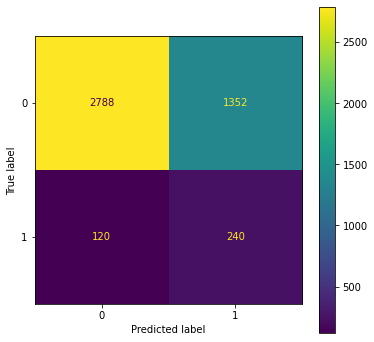

--- ROC AUC ---------------------------------------------------------------------------------------- 



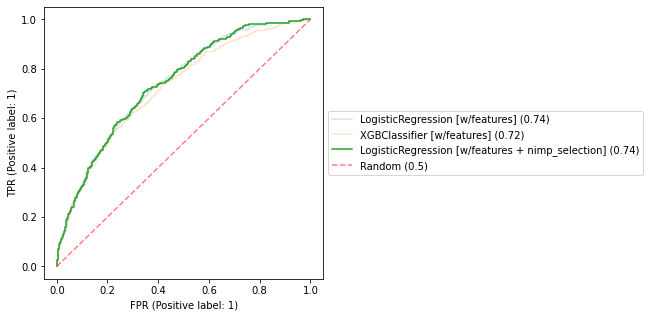

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



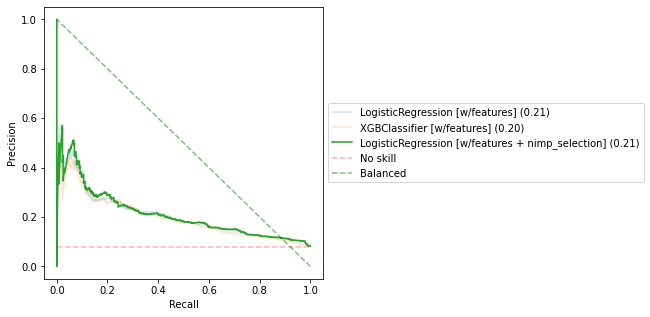

In [61]:
get_scores(f"{model_name} [w/features + nimp_selection]", **grd_log, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [62]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train_s, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23958990536277602) for this model is reached with a threshold of 0.449


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features + nimp_selection] -----------------------------------

             ROC_AUC : 0.7393
                  F1 : 0.2308
            ACCURACY : 0.6060
           PRECISION : 0.1368
              RECALL : 0.7389
   AVERAGE_PRECISION : 0.2108
              CUSTOM : 0.3929

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.59      0.74      4140
Prediction = 1       0.14      0.74      0.23       360

      accuracy                           0.61      4500
     macro avg       0.55      0.67      0.48      45

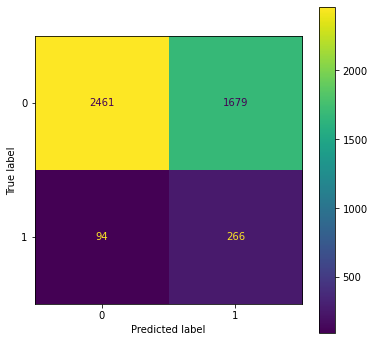

In [63]:
get_scores(f"{model_name} [w/threshold + features + nimp_selection]", **grd_log, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

### Testons l'effet de la selection sur le XGBoost Classifier<a class="anchor" id="models_xgboost_features_selection"></a> [⇪](#menu)

In [64]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid_xgb,
    X_ref=X_train_s,
    y_ref=y_train_s,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7182
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7271
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7102
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7148
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7185

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7177 (std:0.0073)

----------------------------------------------------------------------------------------------------


In [65]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'scale_pos_weight': 11.481644640234949,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 60,
 'max_depth': 3,
 'learning_rate': 0.05,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features + nimp_selection] ----------------------------------------------------

             ROC_AUC : 0.7213
                  F1 : 0.2379
            ACCURACY : 0.6753
           PRECISION : 0.1464
              RECALL : 0.6333
   AVERAGE_PRECISION : 0.2005
              CUSTOM : 0.3804

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.63      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

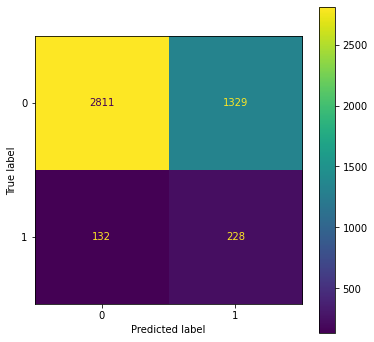

--- ROC AUC ---------------------------------------------------------------------------------------- 



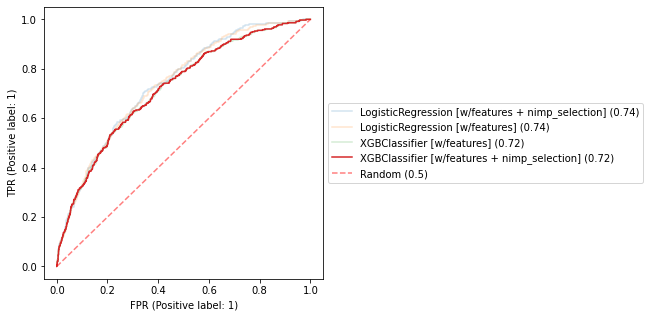

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



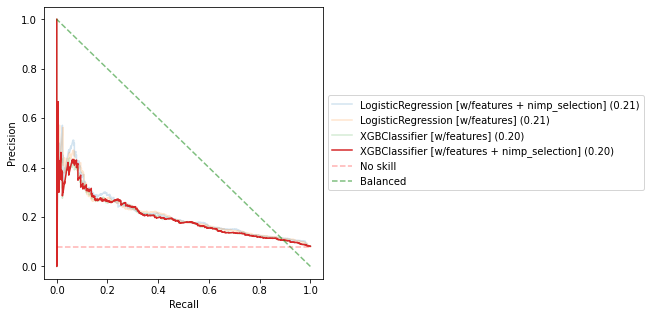

In [66]:
get_scores(f"{model_name} [w/features + nimp_selection]", **grd_xgb, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [67]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train_s, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2507581803671189) for this model is reached with a threshold of 0.462


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/threshold + features + nimp_selection] ----------------------------------------

             ROC_AUC : 0.7213
                  F1 : 0.2268
            ACCURACY : 0.6091
           PRECISION : 0.1347
              RECALL : 0.7167
   AVERAGE_PRECISION : 0.2005
              CUSTOM : 0.3845

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.60      0.74      4140
Prediction = 1       0.13      0.72      0.23       360

      accuracy                           0.61      4500
     macro avg       0.55      0.66      0.48      45

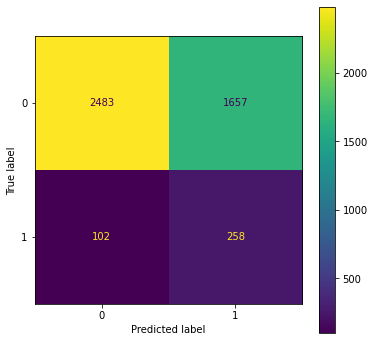

In [68]:
get_scores(f"{model_name} [w/threshold + features + nimp_selection]", **grd_xgb, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

### Revue des scores <a class="anchor" id="models_features_selection_scores"></a> [⇪](#menu)

In [69]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  \
0                   LogisticRegression [w/features]  0.738159  0.245868   
2                        XGBClassifier [w/features]  0.721111  0.239119   
4  LogisticRegression [w/features + nimp_selection]  0.739334  0.245902   
6       XGBClassifier [w/features + nimp_selection]  0.721328  0.237872   

   Precision    Recall  
0   0.151015  0.661111  
2   0.147382  0.633333  
4   0.150754  0.666667  
6   0.146435  0.633333

In [70]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

Method   ROC AUC  F1 score  \
1        LogisticRegression [w/threshold + features]  0.738159  0.219780   
3          XGBClassifier [w/thresholding + features]  0.721111  0.227335   
5  LogisticRegression [w/threshold + features + n...  0.739334  0.230803   
7  XGBClassifier [w/threshold + features + nimp_s...  0.721328  0.226813   

   Precision    Recall  
1   0.127971  0.777778  
3   0.136238  0.686111  
5   0.136761  0.738889  
7   0.134726  0.716667

#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [71]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  \
23                   Balanced LogisticRegression  0.732390  0.240493   
24  Balanced LogisticRegression [w/thresholding]  0.732390  0.199808   
29                        Balanced XGBClassifier  0.721245  0.237675   
30       Balanced XGBClassifier [w/thresholding]  0.721245  0.225911   

    Precision    Recall  
23   0.147541  0.650000  
24   0.112921  0.866667  
29   0.146139  0.636111  
30   0.135434  0.680556

In [72]:
sms.send("Feature selection - Done", stop=False)

### Bilan de la section

> On constate qu'avec la selection de features, le ROC AUC des deux modèles augment légèrement *(par rapport aux scores obtenus avec les nouvelles features)*. On note une lègère baisse sur certains autres scores, mais le Recall et le PR AUC *(qui nous intéressent comme on va le voir plus loin)* sont préservés. Nous allons utiliser cette sélection de features pour la suite de nos recherches.

# 4. Création d'une mesure adaptée au métier <a class="anchor" id="custom_metric"></a> [⇪](#menu)

> Il est parfois utile de créer une `metric` adaptée aux besoins spécifiques d'un projet.
>
>#### Regardons à quoi correspondent les valeurs de nos matrices de confusion pour nous en rendre compte:
> - `(TP) Vrai Positif` : on prédit que le client est à risque, et c'est effectivement le cas. 
>> *(on ne prête pas et on **évite une perte**)*
>
> - `(TN) Vrai Négatif` : on prédit que le client n'est PAS à risque, et c'est effivement le cas.
>> *(on prête et on **gagne** de l'argent)*
>
> - `(FP) Faux Positif` : on prédit que le client est à risque, mais ce n'est PAS le cas.
>> *(on ne prête pas et on **loupe** de l'argent)*
>
> - `(FN) Faux Négatif` : on prédit que le client n'est PAS à risque, mais ce n'est PAS le cas.
>> *(on prête et on **perd** de l'argent)*
>
>
>#### Donc nos objectifs par ordre d'importance sont probablement:
> 1. minimiser les `(FN) Faux Négatifs` pour **éviter de perdre de l'argent**.
> 2. maximiser les `(TP) Vrais Positifs` pour **éviter de perdre de l'argent**.
> 3. maximiser les `(TN) Vrais Négatifs` pour **gagner de l'argent**.
> 4. minimiser les `(FP) Faux Positifs` pour **éviter de louper de l'argent**.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [73]:
from sklearn.metrics import fbeta_score, make_scorer

In [74]:
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=beta_value)
f2_scorer = make_scorer(fbeta_score, beta=beta_value)
#scorer = make_scorer(f1_score)

## Testons les modèles sélectionnés avec la nouvelle metric<a class="anchor" id="custom_metric_test"></a> [⇪](#menu)

### Testons l'effet de la nouvelle metric sur la Logistic Regression <a class="anchor" id="models_linear_custom_metric"></a> [⇪](#menu)

In [75]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,  
    X_ref=X_train_s, # We use the feature selection
    y_ref=y_train_s,
    cv = skfold,
    scoring=f2_scorer
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3825
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3722
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3567
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3608
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3449

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3634 (std:0.0222)

---------------

In [76]:
grd_log['grid'].best_params_

{'C': 6.735020451500072,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features + custom_metric] ------------------------------------------------

             ROC_AUC : 0.7417
                  F1 : 0.2497
            ACCURACY : 0.6756
           PRECISION : 0.1532
              RECALL : 0.6750
   AVERAGE_PRECISION : 0.2098
              CUSTOM : 0.4015

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.68      0.25       360

      accuracy                           0.68      4500
     macro avg       0.56      0.68      0.52      45

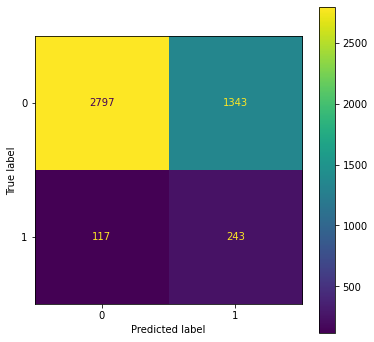

--- ROC AUC ---------------------------------------------------------------------------------------- 



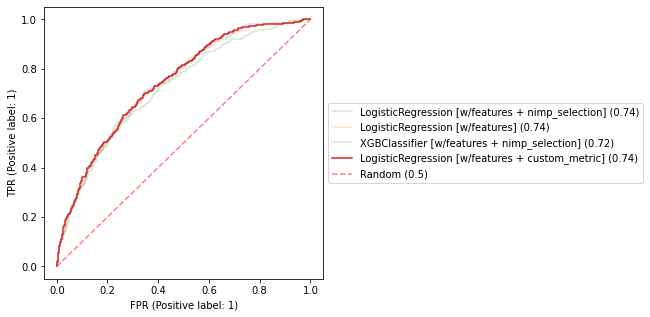

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



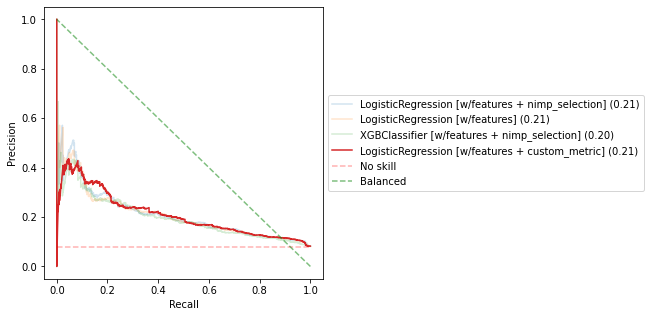

In [77]:
get_scores(f"{model_name} [w/features + custom_metric]", **grd_log, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du Fbeta score)*

In [78]:
f2_value, best_threshold = find_best_threshold(grd_log['model'], X_train_s, y_train_s, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.4196761416589003) for this model is reached with a threshold of 0.488


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features + custom_metric] ------------------------------------

             ROC_AUC : 0.7417
                  F1 : 0.2475
            ACCURACY : 0.6622
           PRECISION : 0.1506
              RECALL : 0.6944
   AVERAGE_PRECISION : 0.2098
              CUSTOM : 0.4032

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.66      0.78      4140
Prediction = 1       0.15      0.69      0.25       360

      accuracy                           0.66      4500
     macro avg       0.56      0.68      0.51      45

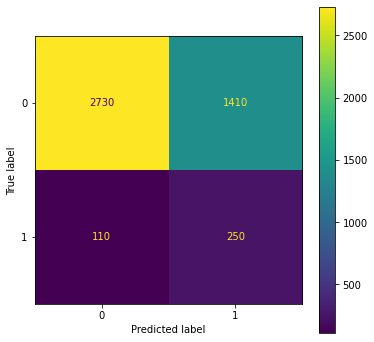

In [79]:
get_scores(f"{model_name} [w/threshold + features + custom_metric]", **grd_log, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

### Testons l'effet de la nouvelle metric sur le XGBoost Classifier<a class="anchor" id="models_xgboost_custom_metric"></a> [⇪](#menu)

In [80]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid_xgb,
    X_ref=X_train_s, # We use the feature selection
    y_ref=y_train_s,
    cv = skfold,
    scoring=f2_scorer,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3447
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3433
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3178
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3426
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3210

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3339 (std:0.0138)

---------------

In [81]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'scale_pos_weight': 11.481644640234949,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 60,
 'max_depth': 3,
 'learning_rate': 0.05,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features + custom_metric] -----------------------------------------------------

             ROC_AUC : 0.7213
                  F1 : 0.2379
            ACCURACY : 0.6753
           PRECISION : 0.1464
              RECALL : 0.6333
   AVERAGE_PRECISION : 0.2005
              CUSTOM : 0.3804

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.63      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

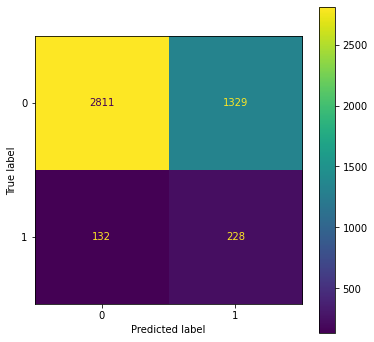

--- ROC AUC ---------------------------------------------------------------------------------------- 



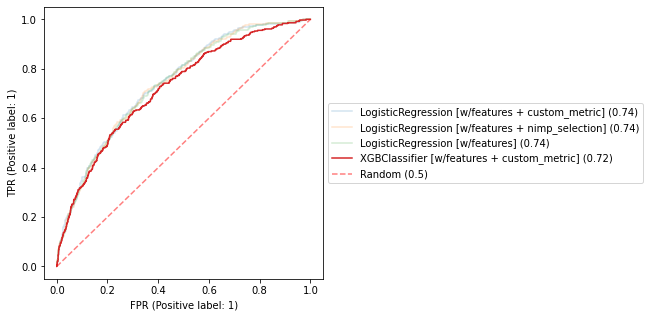

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



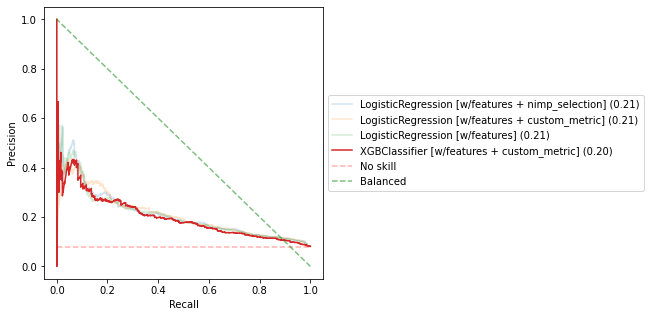

In [82]:
get_scores(f"{model_name} [w/features + custom_metric]", **grd_xgb, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du Fbeta score)*

In [83]:
f2_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train_s, y_train_s, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.4122511637119937) for this model is reached with a threshold of 0.437


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/threshold + features + custom_metric] -----------------------------------------

             ROC_AUC : 0.7213
                  F1 : 0.2147
            ACCURACY : 0.5547
           PRECISION : 0.1250
              RECALL : 0.7611
   AVERAGE_PRECISION : 0.2005
              CUSTOM : 0.3772

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.54      0.69      4140
Prediction = 1       0.12      0.76      0.21       360

      accuracy                           0.55      4500
     macro avg       0.54      0.65      0.45      45

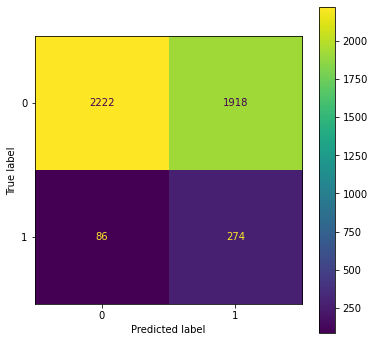

In [84]:
get_scores(f"{model_name} [w/threshold + features + custom_metric]", **grd_xgb, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

### Revue des scores <a class="anchor" id="models_custom_metric_scores"></a> [⇪](#menu)

#### Les scores obtenus avant les tunings de ce notebook

In [85]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  \
23                   Balanced LogisticRegression  0.732390  0.240493   
24  Balanced LogisticRegression [w/thresholding]  0.732390  0.199808   
29                        Balanced XGBClassifier  0.721245  0.237675   
30       Balanced XGBClassifier [w/thresholding]  0.721245  0.225911   

    Precision    Recall  
23   0.147541  0.650000  
24   0.112921  0.866667  
29   0.146139  0.636111  
30   0.135434  0.680556

#### Tous les modèles entrainés sur ROC AUC sans seuillage

In [86]:
scores_df[ ~(scores_df.Method.str.contains('threshold|custom')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall','Custom']]

Method   ROC AUC  F1 score  \
0                   LogisticRegression [w/features]  0.738159  0.245868   
2                        XGBClassifier [w/features]  0.721111  0.239119   
4  LogisticRegression [w/features + nimp_selection]  0.739334  0.245902   
6       XGBClassifier [w/features + nimp_selection]  0.721328  0.237872   

   Precision    Recall    Custom  
0   0.151015  0.661111  0.394562  
2   0.147382  0.633333  0.381654  
4   0.150754  0.666667  0.395778  
6   0.146435  0.633333  0.380380

#### Tous les modèles entrainés sur ROC AUC avec seuillage

In [87]:
scores_df[ ~(scores_df.Method.str.contains('custom')) & (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall', 'Custom']]

Method   ROC AUC  F1 score  \
1        LogisticRegression [w/threshold + features]  0.738159  0.219780   
3          XGBClassifier [w/thresholding + features]  0.721111  0.227335   
5  LogisticRegression [w/threshold + features + n...  0.739334  0.230803   
7  XGBClassifier [w/threshold + features + nimp_s...  0.721328  0.226813   

   Precision    Recall    Custom  
1   0.127971  0.777778  0.385888  
3   0.136238  0.686111  0.379650  
5   0.136761  0.738889  0.392910  
7   0.134726  0.716667  0.384501

#### Tous les modèles entrainés sur F2-Measure

In [88]:
scores_df[ (scores_df.Method.str.contains('custom')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall', 'Custom']]

Method   ROC AUC  F1 score  \
8     LogisticRegression [w/features + custom_metric]  0.741749  0.249743   
9   LogisticRegression [w/threshold + features + c...  0.741749  0.247525   
10         XGBClassifier [w/features + custom_metric]  0.721328  0.237872   
11  XGBClassifier [w/threshold + features + custom...  0.721328  0.214734   

    Precision    Recall    Custom  
8    0.153216  0.675000  0.401520  
9    0.150602  0.694444  0.403226  
10   0.146435  0.633333  0.380380  
11   0.125000  0.761111  0.377203

### Bilan de la section

> Les modèles entrainés avec cette nouvelle metric montrent une lègère baisse sur le ROC AUC (puisqu'ils ne sont plus optimisés sur cette metric) et de la Precision mais aussi une augmentation du Recall (ce qui est plutôt le but recherché pour aider à réduire les FN).

In [89]:
sms.send("New metric - Done", stop=False)

# 5. Augmentation du training-set <a class="anchor" id="extra_data"></a> [⇪](#menu)

Pour diminuer le temps d'exploration des divers modèles, les étapes précédents de ce projet ont été réalisées sur un échantillon de 30000 lignes au lieu des 312000 disponibles.

Maintenant que nous avons un modèle qui nous semble convenir à nos besoins, c'est l'occasion de le ré-entrainer avec un training-set beaucoup plus conséquent, et donc de voir les effets que peuvent provoquer l'apport de nouvelles données d'entrainement.

## Préparons donc les training et testing sets sur la base de l'ensemble du dataset

In [90]:
data_work = data_application_train.copy()

#### Ajoutons les `nouvelles features` au dataset complet

In [91]:
data_work = add_new_features(data_work)

#### Séparons le jeu de données en `train` et `test `

In [92]:
X_train, X_test, y_train, y_test, _, _, _, _ = prepare_dataset(data_work)
X_train_s, X_test_s, y_train_s, y_test_s, _, _, _, _ = prepare_dataset(data_work[[*selected_cols, 'TARGET']])

X_train: 84.9998861829333% | X_test: 15.000113817066707%
X_train: 84.9998861829333% | X_test: 15.000113817066707%


## Entrainons et testons le modèle final avec les colonnes sélectionnées par la feature selection<a class="anchor" id="final_model"></a> [⇪](#menu)

In [93]:
model_name = "Final LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,
    X_ref=X_train_s, # with feature selection
    y_ref=y_train_s,
    cv = skfold,
    scoring=f2_scorer,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3621
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3637
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3995
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3692
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3983

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3786 (std:0.0180)

---------------

In [94]:
grd_log['grid'].best_params_

{'C': 0.2317105870400502,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Final LogisticRegression [w/features + custom_metric + selection] ------------------------------

             ROC_AUC : 0.7559
                  F1 : 0.2655
            ACCURACY : 0.6897
           PRECISION : 0.1641
              RECALL : 0.6947
   AVERAGE_PRECISION : 0.2322
              CUSTOM : 0.4219

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.69      0.80     42403
Prediction = 1       0.16      0.69      0.27      3724

      accuracy                           0.69     46127
     macro avg       0.56      0.69      0.53     461

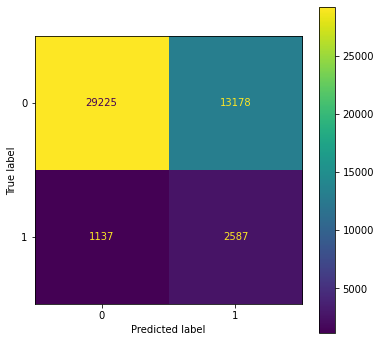

--- ROC AUC ---------------------------------------------------------------------------------------- 



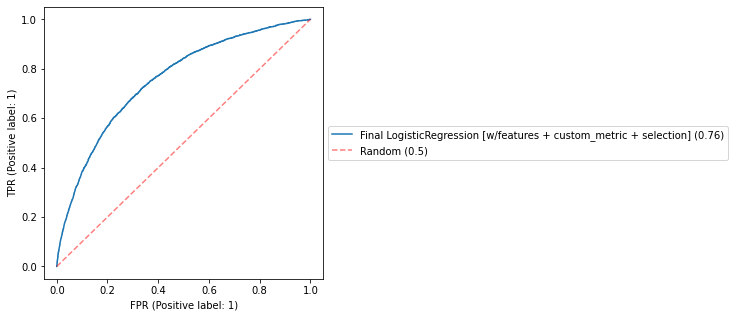

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



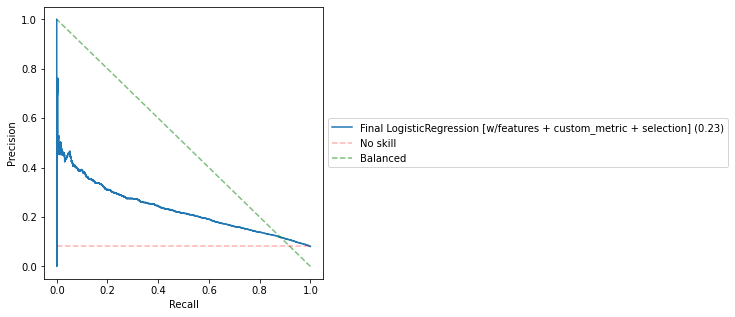

In [95]:
get_scores(f"{model_name} [w/features + custom_metric + selection]", **grd_log, X_ref=X_test_s, register=True, alone=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du Fbeta score)*

In [96]:
f2_value, best_threshold = find_best_threshold(grd_log['model'], X_train_s, y_train_s, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.4011921137093077) for this model is reached with a threshold of 0.425


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Final LogisticRegression [w/threshold + features + custom_metric + selection] ------------------

             ROC_AUC : 0.7559
                  F1 : 0.2377
            ACCURACY : 0.5881
           PRECISION : 0.1397
              RECALL : 0.7954
   AVERAGE_PRECISION : 0.2322
              CUSTOM : 0.4103

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.57      0.72     42403
Prediction = 1       0.14      0.80      0.24      3724

      accuracy                           0.59     46127
     macro avg       0.55      0.68      0.48     461

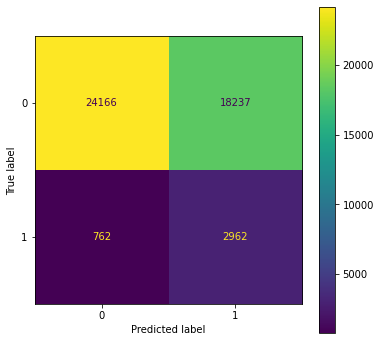

In [97]:
get_scores(f"{model_name} [w/threshold + features + custom_metric + selection]", **grd_log, X_ref=X_test_s, threshold=best_threshold, register=True, show_roccurves=False)

## Entrainons et testons le modèle final avec toutes les colonnes<a class="anchor" id="final_model"></a> [⇪](#menu)

In [98]:
model_name = "Final LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,
    X_ref=X_train, # without feature selection
    y_ref=y_train,
    cv = skfold,
    scoring=f2_scorer,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3643
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3642
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3681
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3713
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3692

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3674 (std:0.0028)

---------------

In [99]:
grd_log['grid'].best_params_

{'C': 0.09469170308457578,
 'class_weight': 'balanced',
 'l1_ratio': 0.925596638292661,
 'max_iter': 3000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Final LogisticRegression [w/features + custom_metric] ------------------------------------------

             ROC_AUC : 0.7574
                  F1 : 0.2683
            ACCURACY : 0.6925
           PRECISION : 0.1660
              RECALL : 0.6982
   AVERAGE_PRECISION : 0.2329
              CUSTOM : 0.4255

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.69      0.81     42403
Prediction = 1       0.17      0.70      0.27      3724

      accuracy                           0.69     46127
     macro avg       0.56      0.70      0.54     461

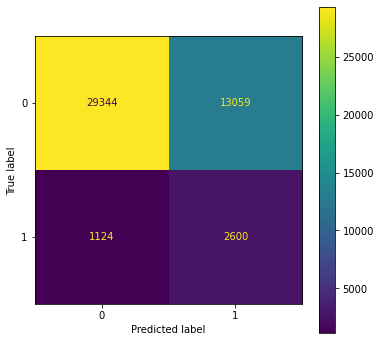

--- ROC AUC ---------------------------------------------------------------------------------------- 



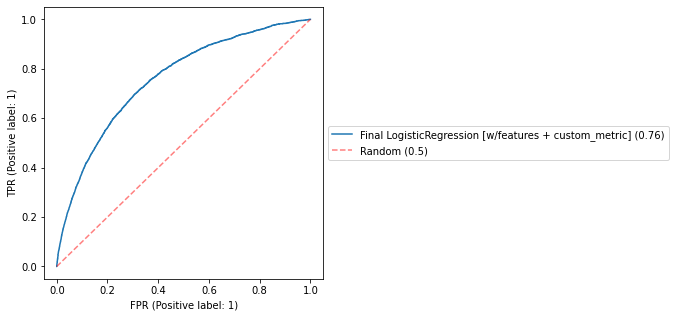

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



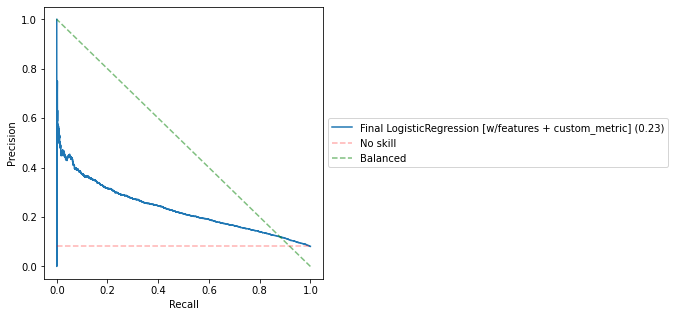

In [100]:
get_scores(f"{model_name} [w/features + custom_metric]", **grd_log, X_ref=X_test, register=True, alone=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du Fbeta score)*

In [101]:
f2_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.40306727218626065) for this model is reached with a threshold of 0.423


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Final LogisticRegression [w/threshold + features + custom_metric] ------------------------------

             ROC_AUC : 0.7574
                  F1 : 0.2383
            ACCURACY : 0.5872
           PRECISION : 0.1400
              RECALL : 0.7997
   AVERAGE_PRECISION : 0.2329
              CUSTOM : 0.4117

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.57      0.72     42403
Prediction = 1       0.14      0.80      0.24      3724

      accuracy                           0.59     46127
     macro avg       0.55      0.68      0.48     461

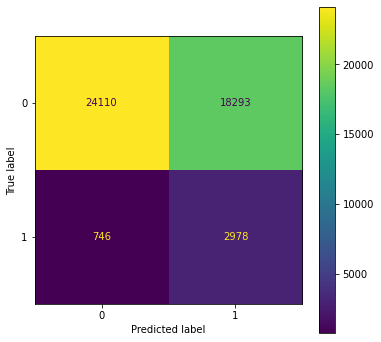

In [102]:
get_scores(f"{model_name} [w/threshold + features + custom_metric]", **grd_log, X_ref=X_test, threshold=best_threshold, register=True, show_roccurves=False)

In [103]:
y_test.value_counts()

0    42403
1     3724
Name: TARGET, dtype: int64

### Bilan de la section

> On constate que l'apport de nouvelles données d'entrainement à considérablement augmentée plusieurs metrics (ROC AUC, Precision, Recall, F1_score). C'est dans notre cas le levier qui a l'éffet le plus notable.

In [104]:
sms.send("Full re-train - Done", stop=False)

# 6. Explicabilité du modèle et des résultats <a class="anchor" id="interpretation"></a> [⇪](#menu)

Dans le domaine de l'intelligence artificielle, l’[explicabilité](https://www.cnil.fr/fr/definition/explicabilite) est la capacité de mettre en relation et de rendre compréhensible les éléments pris en compte par le système d’IA pour la production d’un résultat.

Il y a [plusieurs raisons](https://www.aquiladata.fr/insights/shap-mieux-comprendre-linterpretation-de-modeles) pour lesquelles c'est une bonne idée de pouvoir expliquer les résultats d'un modèle:
> - **Aspect légal** : L’article 22 du RGPD prévoit des règles pour éviter qu'un individu ne subisse des décisions émanant uniquement de machines. Les modèles sans explication risquent d’entraîner une sanction qui peut s’élever à 20 000 000 d’euros ou, dans le cas d’une entreprise, à 4% du chiffre d’affaires mondial total de l’exercice précédent (le montant le plus élevé étant retenu),
> - **Validation du modèle** : Le modèle a une bonne précision, mais nous cherchons à connaître les variables influentes afin de vérifier la cohérence avec la connaissance métier du domaine. D’autre part, pour certaines applications, nous devons également contrôler le risque du modèle, ce qui nécessite une compréhension approfondie de celui-ci,
> - **Explication et recommandation** : Dans notre projet de demande de crédits à la consommation, il est probable que l'on nous demande des explications en cas de refus. Il faut donc pouvoir expliquer au clientles raisons du refus et être en capacité de le conseiller pour une futur demande.

Il existe deux niveaux d'explicabilité qui sont complémentaires et souvent utilisées pour différentes raisons:

> - L'**interpretation globale** qui consiste à définir l’importance des variables du modèle **globalement**. <br>Elle est utile pour vérifier la cohérence du modèle avec les connaissances métiers.
> - L'**interpretation locale** qui consiste à extraire des informations locales **pour des exemples spécifiques** de notre dataset. <br>Elle permet d'exliquer une décision (refus ou acceptation) à un client ou à un supérieur.

In [105]:
import shap

In [106]:
# Linear models

shap_model = grd_log['model']

background = shap.maskers.Partition(X_test, max_samples=100)
explainer = shap.explainers.Linear(shap_model, masker=background, link=shap.links.logit)
shap_values = explainer(X_test)

## Interprétation globale de modèle  <a class="anchor" id="interpretation_globale"></a> [⇪](#menu)

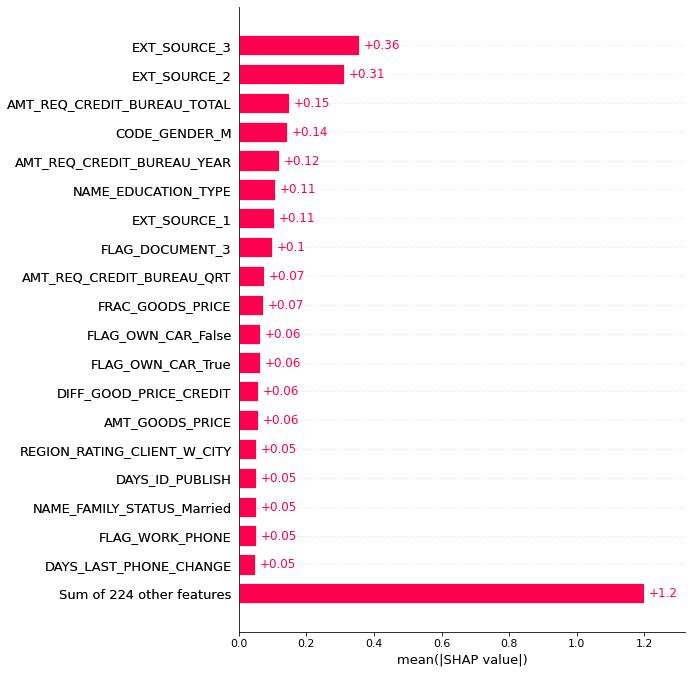

In [107]:
# plot the global importance of each feature
shap.plots.bar(shap_values, max_display=20)

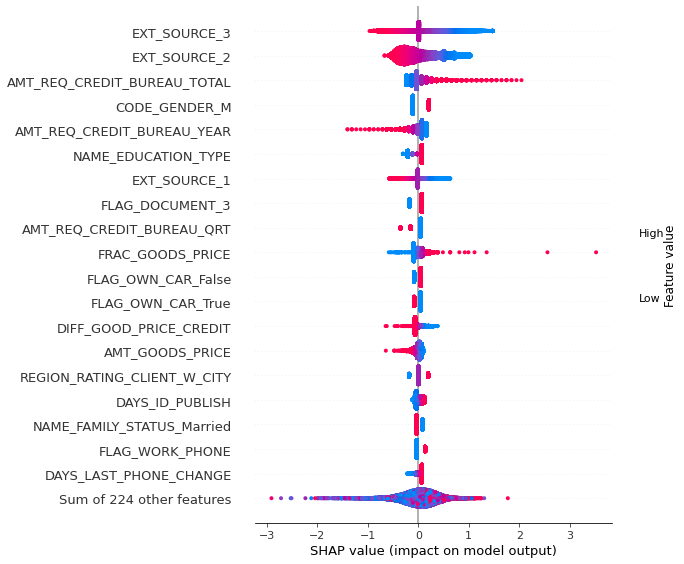

In [108]:
# plot the distribution of importances for each feature over all samples
shap.plots.beeswarm(shap_values, max_display=20)

In [109]:
shap.plots.initjs()
shap.plots.force(shap_values[:500])

## Interprétation locale de modèle  <a class="anchor" id="interpretation_locale"></a> [⇪](#menu)

#### Choisissons un exemple positif auquel on a refusé le crédit *(donc y_pred=1 et y_true=1)*

In [110]:
y_pred = grd_log['model'].predict(X_test)

In [111]:
y_true = y_test.copy()
y_true.reset_index(drop=True, inplace=True)
y_true[ (y_true == 1) & (y_pred == 1) ]

27       1
38       1
57       1
79       1
81       1
        ..
46076    1
46103    1
46109    1
46112    1
46116    1
Name: TARGET, Length: 2600, dtype: int64

>#### Prenons par exemple le 79

In [112]:
index=79

In [113]:
shap_model.predict_proba(X_test[index:index+1])

array([[0.1730309, 0.8269691]])

>#### Il est prédit comme positif avec une probabilité de 82%

In [114]:
pd.DataFrame(X_test.iloc[index]).T

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
262053                            1.0                                 0.0   

        CODE_GENDER_F  CODE_GENDER_M  CODE_GENDER_nan  FLAG_OWN_CAR_False  \
262053            0.0            1.0              0.0                 1.0   

        FLAG_OWN_CAR_True  FLAG_OWN_REALTY_False  FLAG_OWN_REALTY_True  \
262053                0.0                    0.0                   1.0   

        NAME_TYPE_SUITE_Children  NAME_TYPE_SUITE_Family  \
262053                       0.0                     0.0   

        NAME_TYPE_SUITE_Group of people  NAME_TYPE_SUITE_Other_A  \
262053                              0.0                      0.0   

        NAME_TYPE_SUITE_Other_B  NAME_TYPE_SUITE_Spouse, partner  \
262053                      0.0                              0.0   

        NAME_TYPE_SUITE_Unaccompanied  NAME_TYPE_SUITE_nan  \
262053                            1.0                  0.0   

        NAME_INCOME_TYPE_Businessman  NAME_INCOME_TYPE_Commercial associate  \
262053                           0.0                                    1.0   

        NAME_INCOME_TYPE_Maternity leave  NAME_INCOME_TYPE_Pensioner  \
262053                               0.0                         0.0   

        NAME_INCOME_TYPE_State servant  NAME_INCOME_TYPE_Student  \
262053                             0.0                       0.0   

        NAME_INCOME_TYPE_Unemployed  NAME_INCOME_TYPE_Working  \
262053                          0.0                       0.0   

        NAME_FAMILY_STATUS_Civil marriage  NAME_FAMILY_STATUS_Married  \
262053                                0.0                         0.0   

        NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  \
262053                           0.0                                      1.0   

        NAME_FAMILY_STATUS_Widow  NAME_FAMILY_STATUS_nan  \
262053                       0.0                     0.0   

        NAME_HOUSING_TYPE_Co-op apartment  \
262053                                0.0   

        NAME_HOUSING_TYPE_House / apartment  \
262053                                  0.0   

        NAME_HOUSING_TYPE_Municipal apartment  \
262053                                    0.0   

        NAME_HOUSING_TYPE_Office apartment  \
262053                                 0.0   

        NAME_HOUSING_TYPE_Rented apartment  NAME_HOUSING_TYPE_With parents  \
262053                                 0.0                             1.0   

        OCCUPATION_TYPE_Accountants  OCCUPATION_TYPE_Cleaning staff  \
262053                          0.0                             0.0   

        OCCUPATION_TYPE_Cooking staff  OCCUPATION_TYPE_Core staff  \
262053                            0.0                         0.0   

        OCCUPATION_TYPE_Drivers  OCCUPATION_TYPE_HR staff  \
262053                      0.0                       0.0   

        OCCUPATION_TYPE_High skill tech staff  OCCUPATION_TYPE_IT staff  \
262053                                    0.0                       0.0   

        OCCUPATION_TYPE_Laborers  OCCUPATION_TYPE_Low-skill Laborers  \
262053                       0.0                                 0.0   

        OCCUPATION_TYPE_Managers  OCCUPATION_TYPE_Medicine staff  \
262053                       0.0                             0.0   

        OCCUPATION_TYPE_Private service staff  OCCUPATION_TYPE_Realty agents  \
262053                                    0.0                            0.0   

        OCCUPATION_TYPE_Sales staff  OCCUPATION_TYPE_Secretaries  \
262053                          1.0                          0.0   

        OCCUPATION_TYPE_Security staff  OCCUPATION_TYPE_Waiters/barmen staff  \
262053                             0.0                                   0.0   

        OCCUPATION_TYPE_nan  ORGANIZATION_TYPE_Advertising  \
262053                  0.0                            0.0   

        ORGANIZATION_TYPE_Agriculture  ORGANIZATION_TYPE_Bank  \
2620

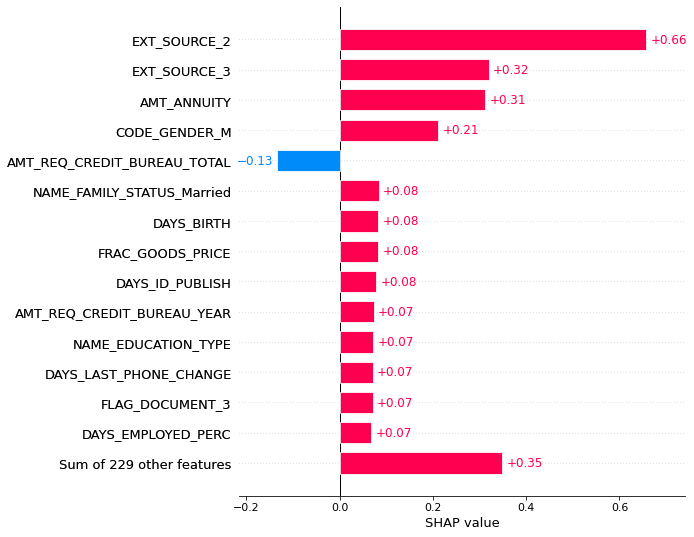

In [115]:
# plot the global importance of each feature for the first prediction
shap.plots.bar(shap_values[index], max_display=15)

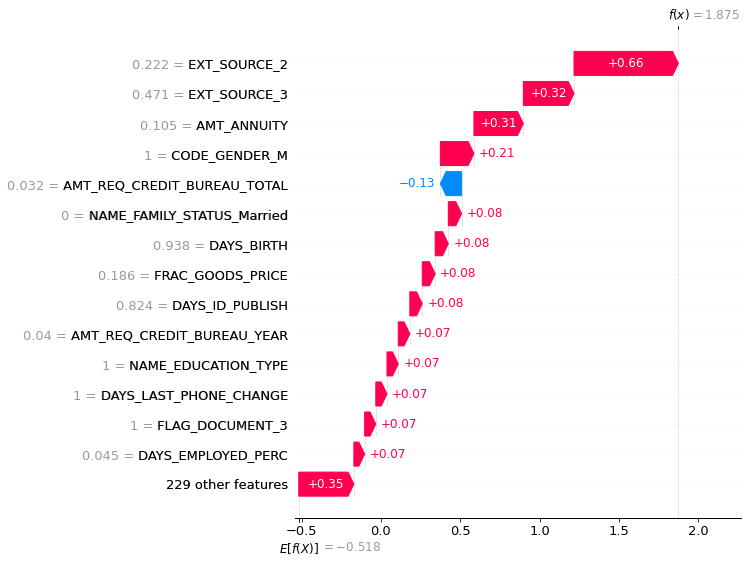

In [116]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[index], max_display=15)

In [117]:
shap.plots.initjs()
# visualize the first prediction's explanation
shap.plots.force(shap_values[index])

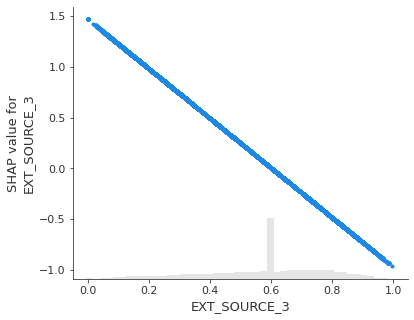

In [118]:
shap.plots.scatter(shap_values[:,"EXT_SOURCE_3"])

In [119]:
sms.send()

JupyterScriptCompleted: Jupyter is waiting